# PCA cross sky subtraction for HETDEX and other spectroscopic datasets

Like pca_sky1, but this notebook tries to use the actual data rather than the sky models.

In [58]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [59]:
import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
from matplotlib import pyplot as plt
% matplotlib inline
from collections import OrderedDict

from astropy.visualization import (MinMaxInterval, ZScaleInterval, SqrtStretch, AsinhStretch,LinearStretch,
                                   ImageNormalize)


import spectrum

In [60]:
def load_spectra(ff):
    """
    Loeads the rebinned an pickeled skys into a convenient datastructure.
    """
    skys = OrderedDict()
    shotids = OrderedDict()
    N = len(ff)
    sff = []
    for i,f in enumerate(ff):
        if i % 100 == 0:
            print("loading {} out of {}.".format(i,N))
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        try:
            ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
            skys[(shotid,exp)] = (rb["sky_subtracted"]+rb["sky_spectrum"])/rb["fiber_to_fiber"] 
            shotids[(shotid,exp)] = f
        except Exception as e:
            print("Error loading {}: {}".format(f, str(e)))
            pass
    print("starting wl = ", ww[0], "A")
    return ww, skys, sff

In [61]:
# Here we read which shots shoudl be used for the computation 
# of the PCA comonents. These may or may not contain the shot for which we actually want to execute the sky subtraction.
fn_shotlist_pca = "data/shotlist_pca_COSMOSA.txt"
IFU = "022"
AMP = "LL"
FIBER = 75

with open(fn_shotlist_pca, 'r') as f:
    s = f.read()
shotlist_PCA = s.split()


In [62]:
# We find all precomputed, rebinned pickle files. 
ff=[]
for shot in shotlist_PCA:
    if shot.startswith("#"):
        continue
    cmd = "ls data/rebin/{}/exp0?/multi_???_{}_???_{}_rebin.pickle".format(shot, IFU, AMP)
    tmp = !$cmd
    ff += tmp

# and actually load the data.
skys = OrderedDict()
ww,skys[(IFU,AMP)],sff = load_spectra(ff)

loading 0 out of 366.


/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


loading 100 out of 366.
loading 200 out of 366.
loading 300 out of 366.
starting wl =  3494.74 A


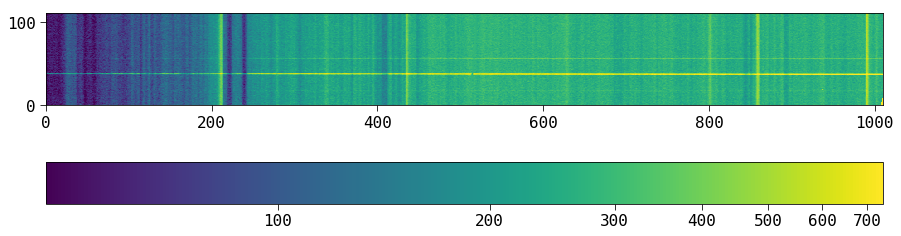

In [64]:

# Plot a random spectrum
image = skys[('022', 'LL')][('20180104v007', 'exp01')]

# Create an ImageNormalize object
norm = ImageNormalize(image, interval=ZScaleInterval(),
                      stretch=AsinhStretch())

# or equivalently using positional arguments
# norm = ImageNormalize(image, MinMaxInterval(), SqrtStretch())

# Display the image
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(image, origin='lower', norm=norm)
fig.colorbar(im, orientation='horizontal')


In [65]:
# A generically stands for the data that we use as input for the sky reconstruction.
# here it is ALL fibers in ifu IFU and amp AMP
XA = np.array( [ biweight_location( skys[(IFU, AMP)][k], axis=0 )  for k in skys[(IFU, AMP)] ] )

# B generically stands for the spactuem for which we want to reconstruc the sky from the PCA components.
# Here we select fiber 75 in IFU 022 and lower left amp (LL).

XB = np.array( [skys[(IFU, AMP)][k][FIBER] for k in skys[(IFU, AMP)] ] )

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 3 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/astropy/stats/biweight.py:117: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 6 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 7 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anac

In [66]:
# hack to homogenize lengths, the rebinning does make sure
# that the wavelength grid always stars at the same wavelength
# but not necessarey, end at the same ( ther may be a few pixel more or less)
N = np.min([XA.shape[1], XB.shape[1], ww.shape[0]])
ww = ww[:N]
XA = XA[:,:N]
XB = XB[:,:N]
# selct wavelength subrange
#wstart = 4626.668686
#wend  = 5400.
wstart = 3495.
wend = 5493.
wend = 5454.76 # masking out one bad feature at the red end

#ww = 
ii = (ww >= wstart) * (ww <= wend)

wwcut = ww[ii]
XAcut = XA[:,ii]
XBcut = XB[:,ii]

300 of 366 survive cut.


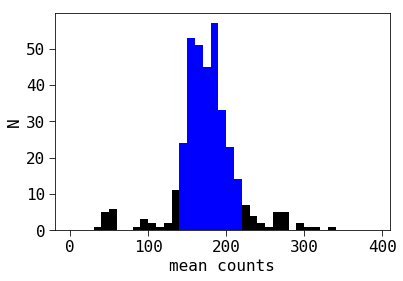

In [67]:
# here we apply cuts to reject sky spectra that have 
# usually high (or low) fluxes. Probably those were taken in bad condition.
#mm = np.mean( XAcut[:,125:225], axis=1)
mm = np.mean( XAcut[:,450:600], axis=1)

plt.hist(mm,bins=np.arange(0,400,10))


start, stop = 140., 220.
jj = (mm > start) * (mm < stop)

plt.hist(mm[jj],bins=np.arange(0,400,10))

print("{} of {} survive cut.".format(np.sum(jj),len(jj)))
plt.xlabel("mean counts")
plt.ylabel("N")


kk = jj # here we could apply further filters

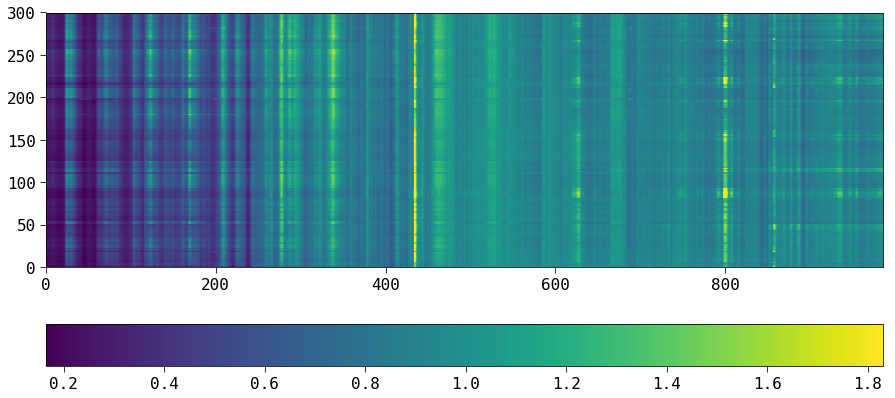

In [68]:
# Lets see what we got, plot all spectra that will
# enter the PCA computation.

image = (XAcut.T/mm).T[jj*kk]

# Create an ImageNormalize object
norm = ImageNormalize(image, interval=ZScaleInterval(),
                      stretch=LinearStretch())

# Display the image
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(image, origin='lower', norm=norm)
fig.colorbar(im, orientation='horizontal')

In [69]:
# finally really apply the filter
XAcut = XAcut[jj*kk]
XBcut = XBcut[jj*kk]

In [70]:
# This is for testing:
# Add synthetic lines in every B - spectrum
# random wavelength
# random sigma (3.5 - 10. A)
# random amplitude (20 - 100. A)
if True:
    #generic gaussian
    def gauss(mu, sigma, x):
        return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

    gg = []
    
    for i in range(XBcut.shape[0]):
        mu = np.random.uniform()* (wwcut[-1] - wwcut[0]) + wwcut[0]
        sigma = np.random.uniform() * 10. + 3.5
        A = np.random.uniform() * 90. + 50.

        g = A*gauss(mu, sigma, wwcut)

        XBcut[i]  = XBcut[i] + g
        
        gg.append(g)

In [71]:
# This is the first essential step of the PCA, we subtract the respective sample mean
MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

MB = np.mean(XBcut,axis=0)
XBmean = XBcut - MB

In [72]:
np.std(XAmean)

20.798670662042664

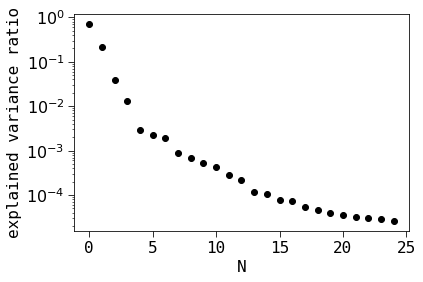

In [73]:
# Plot to help estimate the number of required PCA components.
# variance vs. number of components.

n_components = 25
pcaA = PCA(n_components=n_components)
pcaA.fit(XAmean)
plt.plot(pcaA.explained_variance_ratio_, 'o')  
plt.xlabel("N")
plt.ylabel("explained variance ratio")
plt.yscale('log')

In [49]:
# project pca componets onto
# mean shifted input spectra
ccA = np.inner(XAmean,pcaA.components_)

# reconstruct pca comonents through linear combination
rcA = np.matmul( XAmean.T, ccA).T
# they wont be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

#rc = rc/np.linalg.norm(rc,axis=1)

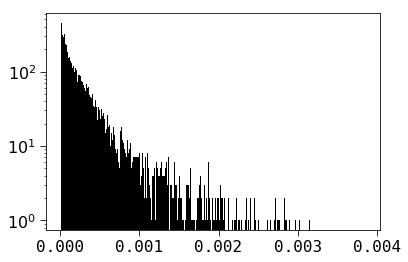

In [50]:
# make sure the result is the same
(np.abs( rcA - pcaA.components_) < 1e-6).all()

dd = np.abs( rcA - pcaA.components_).flatten()

__ = plt.hist(np.abs( rcA - pcaA.components_).flatten()  , bins=np.arange( dd.min() ,dd.max() , 1e-5)[1:] )
plt.yscale("log")

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


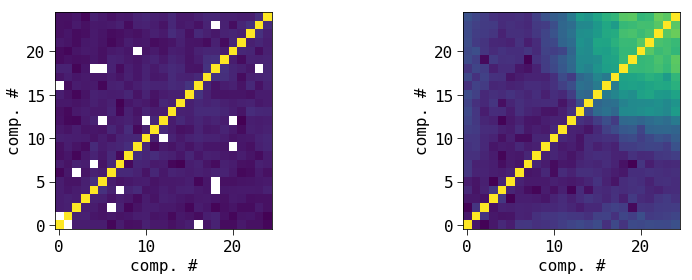

In [74]:
# the othogonality plot
if True:
    f = plt.figure(figsize=[12,4])
    plt.subplot(121)
    plt.imshow(  np.log( np.abs(np.matmul(pcaA.components_, pcaA.components_.T ))), origin='bottom')
    plt.xlabel("comp. #")
    plt.ylabel("comp. #")
    plt.subplot(122)
    plt.imshow( np.log( np.abs(np.matmul(rcA, rcA.T )) ), origin='bottom')
    plt.xlabel("comp. #")
    plt.ylabel("comp. #")
    f.tight_layout()

In [75]:
np.abs( rcA - pcaA.components_).flatten().max()

0.5464075881107342

In [76]:
# compute projection of input spectra onto PCA basis
tA = pcaA.transform(XAmean)

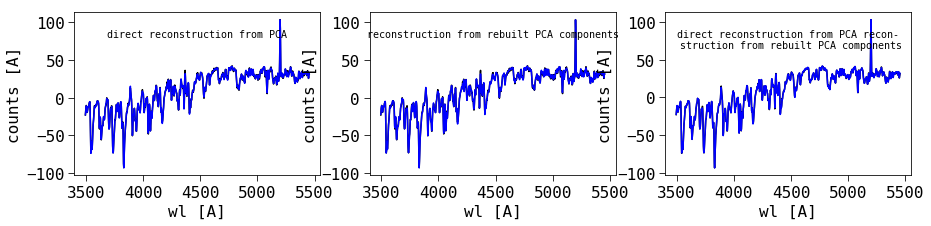

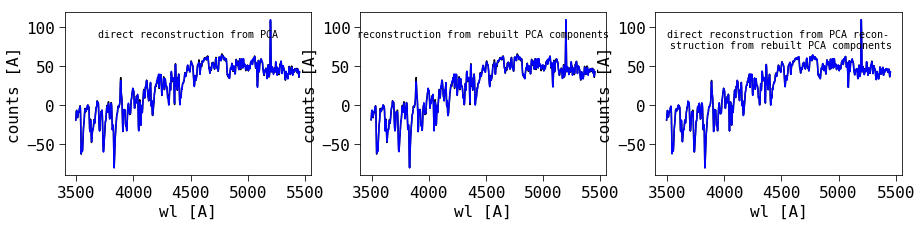

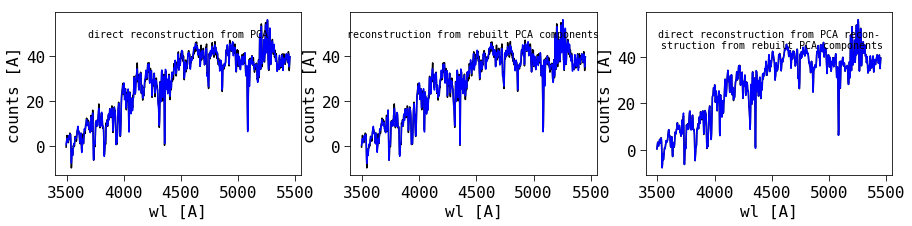

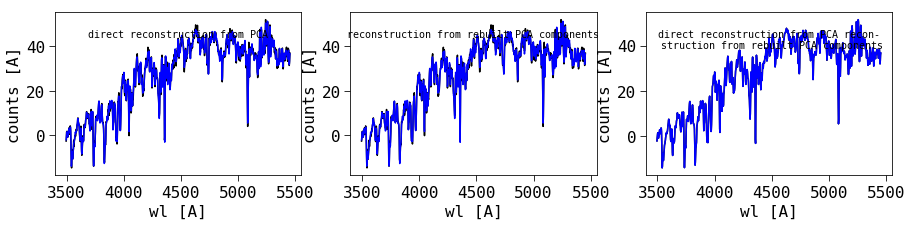

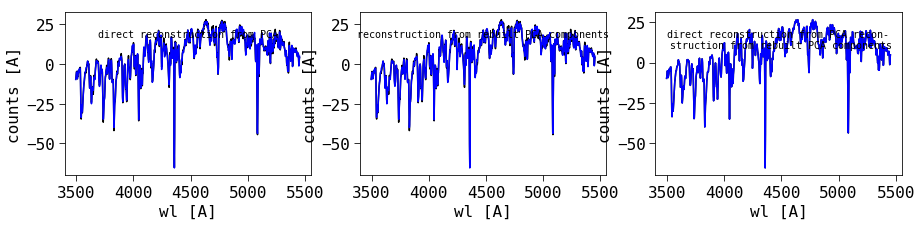

In [77]:
# make sure we can reconstruct the spectra from the
# actual principal components but also from the reconstructed ones
for i in range(5):
    f = plt.figure(figsize=[15,3])
    # plotting input mean spectra and
    # direct reconstruction from PCA
    ax1 = plt.subplot(131)
    plt.plot( wwcut, XAmean[i] )
    # next two lines must have identical result
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    #plt.plot( wwcut, pcaA.inverse_transform(tA)[i] )
    plt.xlabel("wl [A]")
    plt.ylabel("counts [A]")
    plt.text(.5,.9,"direct reconstruction from PCA", transform=ax1.transAxes, ha='center',va='top')

    ax2 = plt.subplot(132)
    # plotting input mean spectra and
    #  reconstruction from rebuilt PCA components
    plt.plot( wwcut, XAmean[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )
    plt.xlabel("wl [A]")
    plt.ylabel("counts [A]")
    plt.text(.5,.9,"reconstruction from rebuilt PCA components", transform=ax2.transAxes, ha='center',va='top')

    ax3 = plt.subplot(133)
    # plot
    # direct reconstruction from PCA
    # and reconstruction from rebuilt PCA components
    # (but not input spectra)
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )
    plt.xlabel("wl [A]")
    plt.ylabel("counts [A]")
    plt.text(.5,.9,"direct reconstruction from PCA recon-\n struction from rebuilt PCA components", transform=ax3.transAxes, ha='center',va='top')

In [78]:
# This reconstructs pca components of B through linear combination of spectra from B
# BUT using projection from A
rcB = np.matmul( XBmean.T, ccA).T
# they wont be normalized yet
for i,cB in enumerate(rcB):
    rcB[i] = rcB[i]/np.linalg.norm(rcB[i])

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


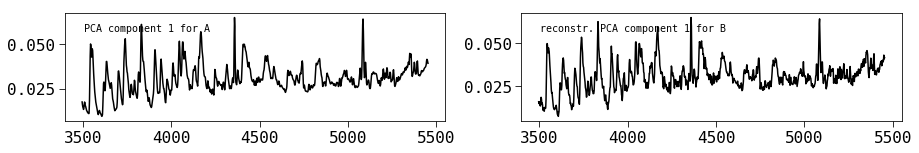

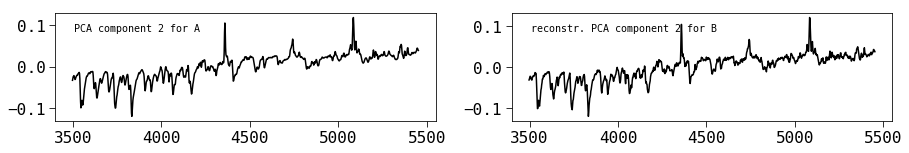

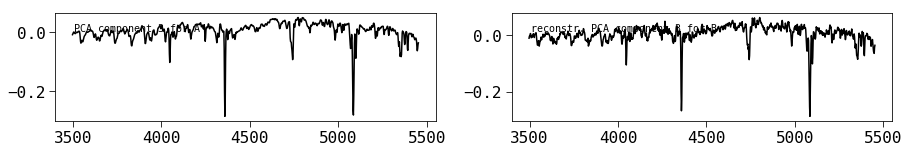

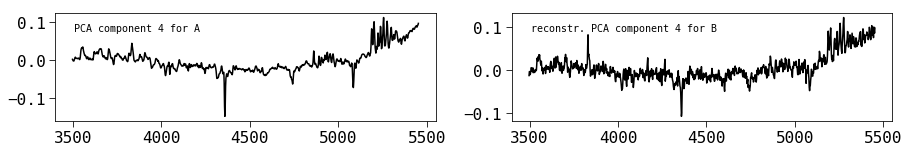

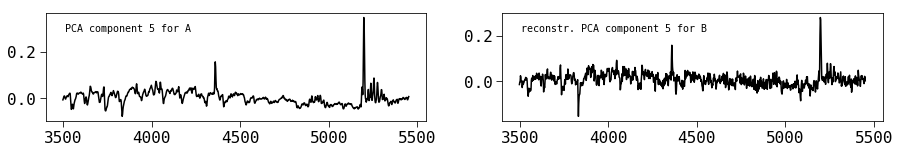

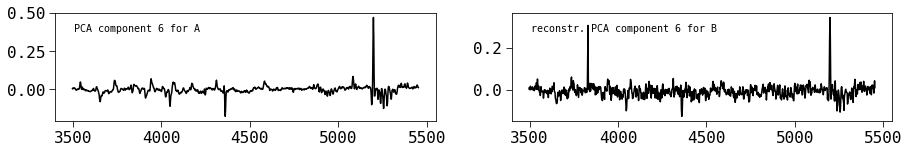

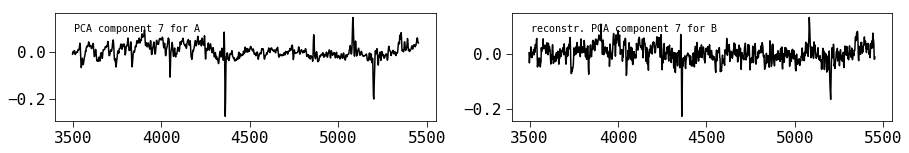

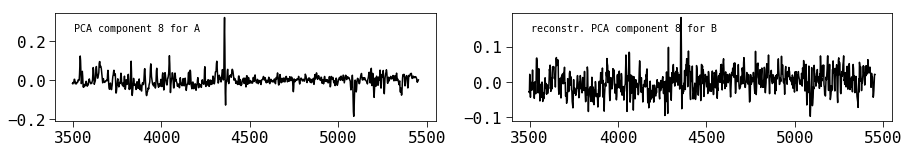

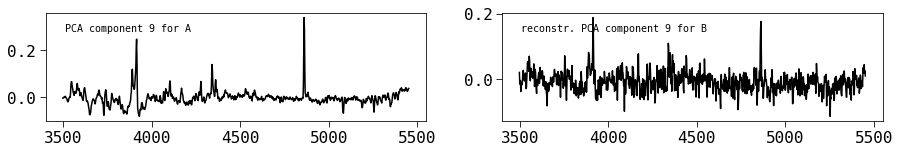

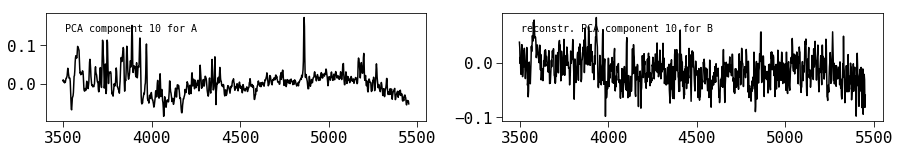

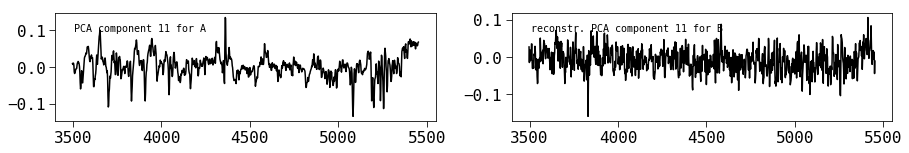

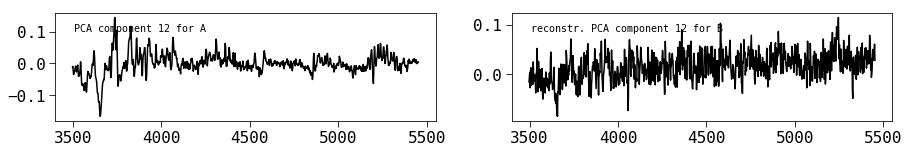

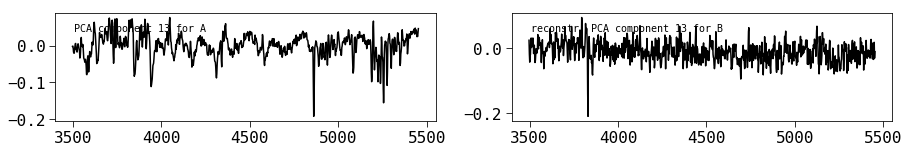

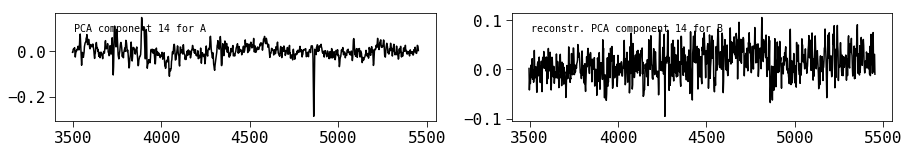

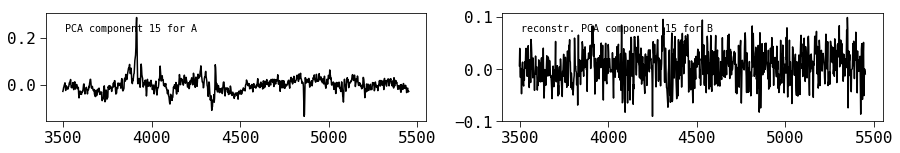

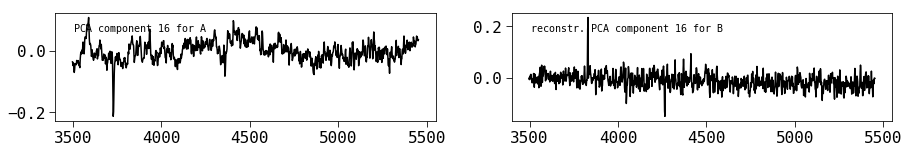

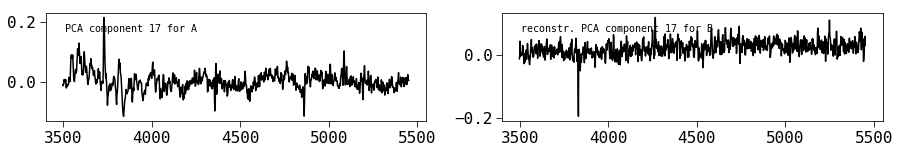

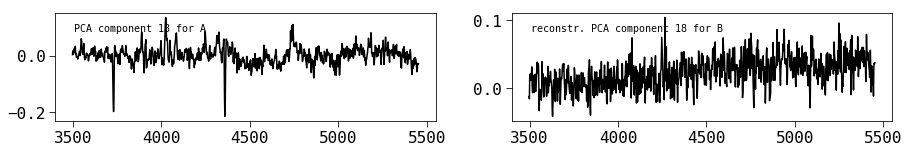

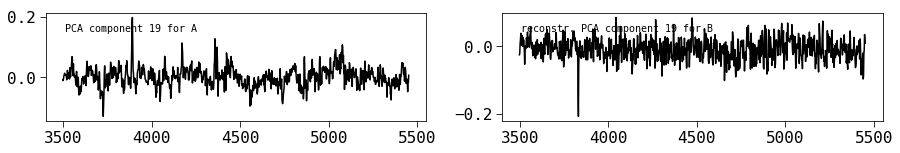

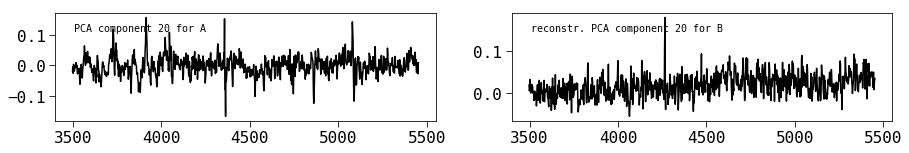

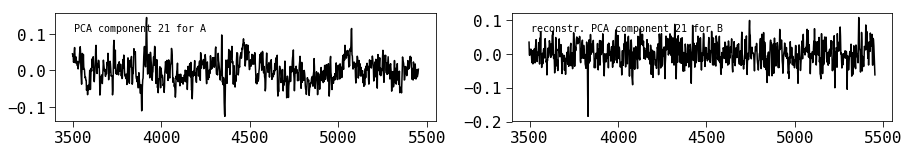

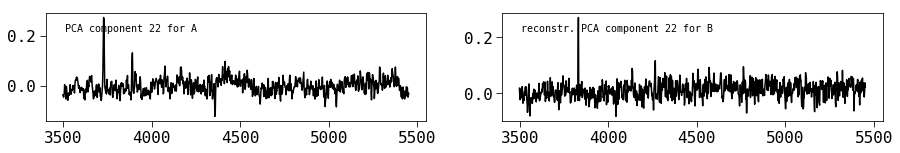

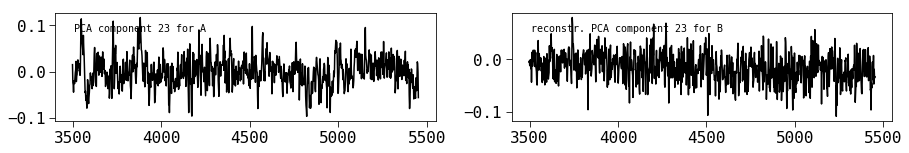

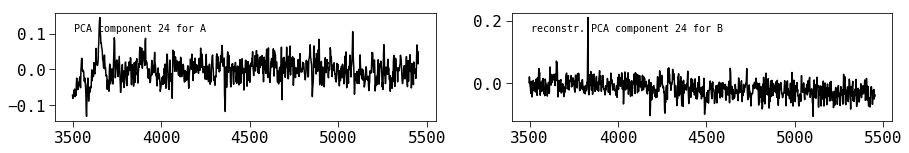

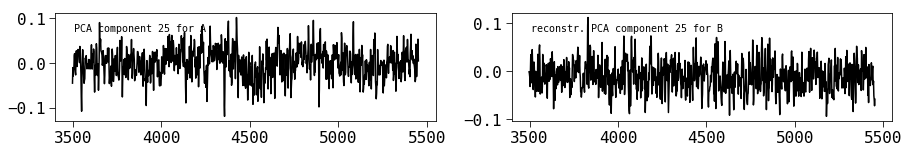

In [85]:
# plot PCA components for A and B
for i in range(pcaA.n_components):
    f = plt.figure(figsize=[15,2])
    
    ax1 = plt.subplot(121)
    plt.plot( wwcut, pcaA.components_[i] )
    plt.text(.05,.9, "PCA component {} for A".format(i+1), transform=ax1.transAxes, va='top', ha='left')
    ax2 = plt.subplot(122)
    plt.plot( wwcut, rcB[i] )    
    plt.text(.05,.9, "reconstr. PCA component {} for B".format(i+1), transform=ax2.transAxes, va='top', ha='left')

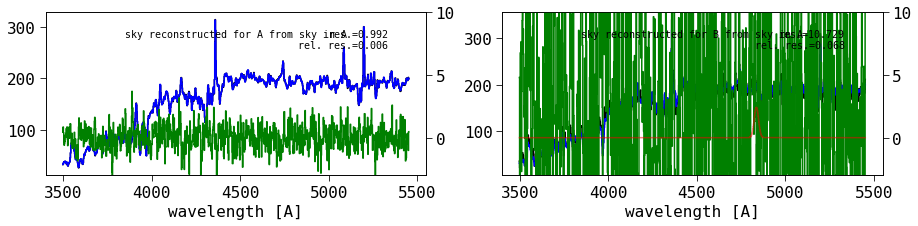

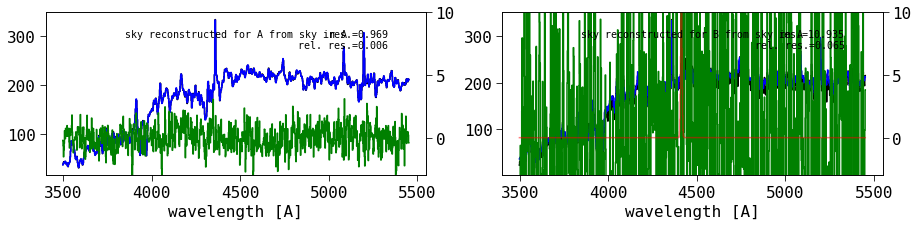

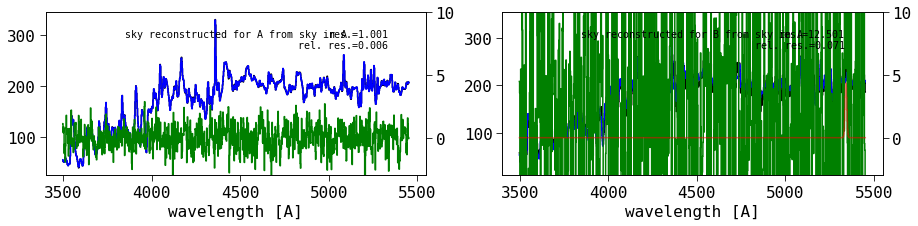

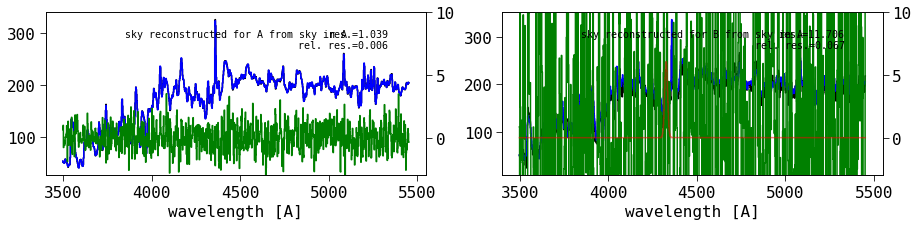

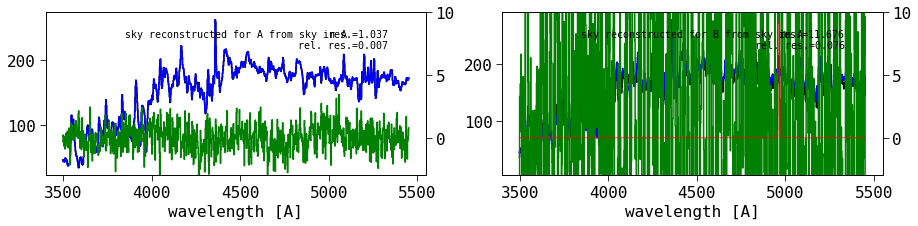

In [56]:
# Finally, check how well we are doing:
# Make sure we can reconstuct the spectra from the
# actual principal components for A but also from the reconstructed ones for B
for i in range(5):
    f = plt.figure(figsize=[15,3])
    ax = plt.subplot(121)
    
    y  = XAmean[i] + MA
    ry = np.inner(tA, pcaA.components_.T)[i] + MA
    res = ry-y
    plt.plot(wwcut,  y , drawstyle='steps-mid' )
    plt.plot(wwcut, ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid' )
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    plt.text(.5,.9,"sky reconstructed for A from sky in A", transform=ax.transAxes, ha='center',va='top')
    

    ax = plt.subplot(122, sharex=ax)
    
    y  = XBmean[i] + MB
    ry = np.inner(tA, rcB.T)[i] + MB
    res = y-ry
    
    plt.plot(wwcut,   y , drawstyle='steps-mid' )
    plt.plot(wwcut,   ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid')
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    plt.text(.5,.9,"sky reconstructed for B from sky in A", transform=ax.transAxes, ha='center',va='top')

    plt.plot(wwcut,   gg[i], 'r-' , drawstyle='steps-mid', alpha=.5)


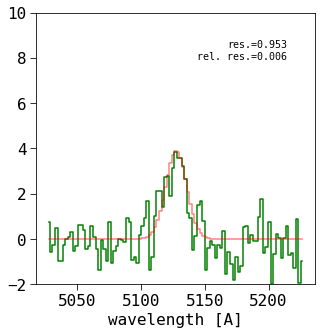

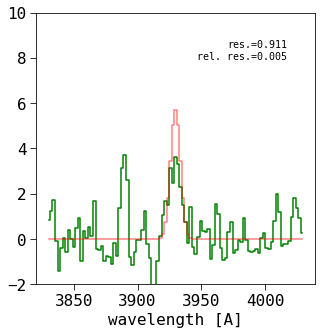

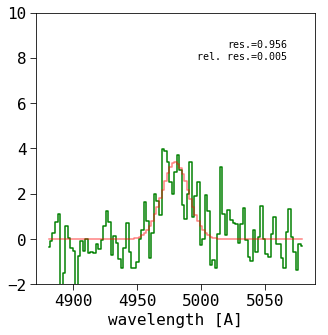

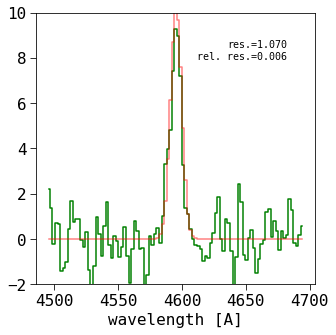

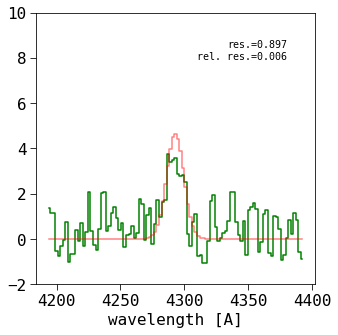

In [26]:
# Almost same as last cell, but here zoom in onto fake emission lines. Make sure they are not getting removed.
for i in range(5):
    f = plt.figure(figsize=[5,5])
    ax = plt.subplot()
    y  = XBmean[i] + MB
    ry = np.inner(tA, rcB.T)[i] + MB
    res = y-ry

    wc = wwcut[np.argmax(gg[i])]
    ii = (wwcut > (wc-100.)) * (wwcut < (wc+100.))

    plt.plot(wwcut[ii],   res[ii], 'g-' , drawstyle='steps-mid')
    plt.ylim([-2,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')

    plt.plot(wwcut[ii],   gg[i][ii], 'r-' , drawstyle='steps-mid', alpha=.5)

    plt.xlabel("wavelength [A]")